# 4b) Akustik Öznitelikler ile Otomatik Enstrüman Tanıma

<a href="https://colab.research.google.com/drive/1I3T54-1S0surU6GwY08ESJ65b1V6Sz8H?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Otomatik ses sınıflandırma

Otomatik ses sınıflandırma, verilen bir ses kaydının  tanımlanmış kategorilerden hangisine ait olduğunun otomatik bulunması işlemidir ve giderek artan sayıda uygulamada kullanılmaktadır. Bu uygulamalara örnek olarak [çevresel ses sınıflandırma](https://paperswithcode.com/task/environmental-sound-classification), [konuşma tanıma](https://paperswithcode.com/task/speech-recognition) (bu problemde kaydın küçük kesitleri sınıflandırılmaktadır), [hastalık tespiti için kalp sesi sınıflandırması](https://paperswithcode.com/task/ecg-classification) gibi örnekler verilebilir. Bu bölümde amacımız otomatik enstrüman sesi sınıflandırması problemi üzerinden otomatik ses sınıflandırması sistem tasarımı problemini ele almak ve ilgili okuyuculara bu konu için bir başlangıç noktası sağlamaktır. İçerik, araştırma materyalinden çok eğitim materyali olarak düşünülmelidir. Bu konudaki güncel araştırmalara ulaşmak için [Google Scholar](https://scholar.google.com/scholar?as_ylo=2017&q=musical+instrument+classification&hl=en&as_sdt=0,5) üzerinden makalelere erişmenizi ve incelemenizi öneririz. 

Herhangi bir makine öğrenmesi problemini ele alırken öncelikle aşağıdaki adımları izlemeliyiz:

*   Hedeflenen uygulamanın ya da araştırma probleminin sınırlarının net bir şekilde tanımlanması
*   Test edilecek modellerin listelenmesi
*   Ölçme ve değerlendirme kriterlerinin belirlenmesi
*   Kullanılacak verilerin elde edilmesi, etiketlerin incelenmesi ve veriler üzerinde yapılacak ön işlemlere karar verilmesi

Bu konuları ele almadan önce ilgili konuda literatür taraması yapmak, en azından güncel bir literatür özet makalesi okumakta büyük fayda vardır.  

Yukarıdaki maddeleri ele alırken, "Evrensel kümemiz nedir?", "Hangi verileri toplayabilirim?", "Topladığım verilerin güvenilir etiketleri var mı? Yoksa bu etiketleri nasıl toplar/edinirim?" sorularını da sürekli olarak sorgulamalıyız.

![Akis](https://github.com/ses-isleme/ses-isleme.github.io/raw/main/static/img/otomatik-enstruman-tanima/genel-akis.png)

Şekil 7.1: Veri uzayı ve tasarım öğeleri

Bu problemde sınırları şu şekilde belirledik:

*   Gürültüsüz stüdyo ortamında monofonik olarak (tek enstrümanla icra edilen) izole nota seslendirmeleri olarak kaydedilmiş seslerin otomatik sınıflandırması üzerine çalışacağız. Nota seslendirmelerini 4 farklı kategoride (flüt, klarinet, viyolin, vibrafon) sınıflandıracağız.
*   sklearn kütüphanesinde mevcut bir dizi otomatik sınıflandırıcı modelini test edip karşılaştıracağız
*   Ölçüt olarak standart otomatik sınıflandırma ölçütlerini kullanılacağız (kesinlik, doğruluk, vb.)
*   Veri kümesi olarak bir konservatuvar sitesinde bulunan verileri kullanacağız [*the IOWA:MIS dataset*](http://theremin.music.uiowa.edu/MIS.html) Bu veri setinin seçerken etiketlerin dosya isimlerinde mevcut olması ve ekstra etiketleme emeğine ihtiyaç duymamasına dikkat ettik.

## Bölüm organizasyonu

Daha kolay takip edilebilmesi için bölümü üç aşamaya ayırdık. 

1.   **Veri inceleme ve ön işleme:** Öncelikle verileri indirip inceleyecek, içeriğini anlamaya çalışacak ve testlerde kullanılabilmesi için bir dizi ön işleme adımına tabi tutacağız. Veriler üzerine inceleme yapmak problemin doğasını anlamak için kullanılmasını şiddetle tavsiye ettiğimiz bir yöntemdir. Uygun temsillerin ve modellerin seçilebilmesi için önemli bir gerekliliktir.
2.   **Öznitelik hesaplama:** Her bir örnek/kayıt için öznitelikleri hesaplayacak ve öznitelik uzayında bazı incelemeler yapacağız. Daha iyi sonuçlar alabilmek için öznitelikler üzerinde uygulayabileceğimiz bir dizi ön işleme adımını ele alacağız.
3.   **Sınıflandırıcı tasarımı ve testleri**: Bu noktada `sklearn` kütüphanesinde varolan hazır tasarımları kullanacak ve veriler üzerinde performanslarını karşılaştıracağız.

**Temel kütüphaneleri yükleyerek kodumuza başlayabiliriz:**



In [3]:
%%capture --no-display
# Kütüphanelerin yüklenmesi
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython
import warnings
warnings.filterwarnings('ignore')

# Ses verisi okuma ve öznitelik kestirimi için Essentia paketinin kurulumu
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia
import essentia.standard as ess

# Rasgelelik kontrolü için 'seed' ekleyelim
np.random.seed(0)

## Ham verinin toplanıp incelenmesi 

**Dosyaların indirilmesi:**
Öncelikle internetten zip dosyalarını indirip içindekileri 'instrument' isimli bir klasörde toplayalım.

In [4]:
%%capture --no-display
%%capture --no-stderr
%%capture --no-stdout
# UIOWA:MIS veri kümesinden örneklerin indirilmesi
import urllib.request
import zipfile
import os
import sys
import shutil

# UIOWA:MIS veri kümesi bağlantı adresleri
baglantilar = {
    'flute': 'http://theremin.music.uiowa.edu/sound%20files/MIS/Woodwinds/flute/flute.nonvib.ff.zip',
    'violin': 'http://theremin.music.uiowa.edu/sound%20files/MIS/Strings/violin2012/Violin.arco.mono.1644.1.zip',
    'vibraphone': 'http://theremin.music.uiowa.edu/sound%20files/MIS%20Pitches%20-%202014/Percussion/Vibraphone/Vibraphone.dampen.ff.stereo.zip',
    'clarinet': 'http://theremin.music.uiowa.edu/sound%20files/MIS/Woodwinds/Ebclarinet/EbClar.ff.zip'
}

veri_klasoru = 'instrument'
if not os.path.exists(veri_klasoru):  # klasör yok ise oluşturalım
    os.mkdir(veri_klasoru)
for enstruman, url in baglantilar.items():
    print(enstruman, 'için dosyaları indiriyor')
    hedef_klasor = os.path.join(veri_klasoru, enstruman)
    # enstrüman için altklasör yok ise oluşturalım
    if not os.path.exists(hedef_klasor):
        os.mkdir(hedef_klasor)
    dosya_ismi = url.split('/')[-1]
    urllib.request.urlretrieve(url, dosya_ismi)
    # Zip dosyasının açılması
    zip_ref = zipfile.ZipFile(dosya_ismi, 'r')
    zip_ref.extractall(hedef_klasor)
    zip_ref.close()
    os.remove(dosya_ismi)  # açılmış zip dosyasının silinmesi
    print('Veri indirildi, açıldı ve yerleştirildi: ', hedef_klasor)

### Enstrüman dosya listelerinin toplanması

Klasöre çıkarttığımız dosyaların listesini oluşturmalıyız. Dosyalara sırasıyla bu liste üzerinden erişeceğiz.

In [5]:
veri_klasoru = 'instrument'
# Her enstrüman için dosya listesi taşıyacak kütüphane tanımlayıp kullanalım
enstruman_dosyalari = dict()
# Tüm alt klasörler içerisindeki .aif, .aiff dosyalarının listesini toplama
# Enstrüman etiketi dosya isminde mevcut, bu bilgiyi dosya isminden çekeceğiz
for kok_klasor, klasorler, dosyalar in os.walk(veri_klasoru):
    for dosya in dosyalar:
        # .ff. içeren ses dosyalarını kullanacağız
        if (dosya.endswith('.aif') or dosya.endswith('.aiff')) and '.ff.' in dosya:
            dosya_ismi = os.path.join(kok_klasor, dosya)
            enstruman = dosya.split('.')[0]
            # bu kontrol MACOS'te ._ ile başlayan dosya adları düşünülerek eklendi
            if len(enstruman) > 0:
                if enstruman not in enstruman_dosyalari:
                    enstruman_dosyalari[enstruman] = [dosya_ismi]
                else:
                    enstruman_dosyalari[enstruman].append(dosya_ismi)

# Oluşturduğumuz dosya listesine bakalım
enstruman_dosyalari

{'Vibraphone': ['instrument/vibraphone/Vibraphone.dampen.ff.Bb5.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Ab5.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Ab4.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Db3.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.E5.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Db5.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.E6.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Eb6.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Gb5.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.G4.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Gb4.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.F5.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.F3.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.Bb3.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.D6.stereo.aif',
  'instrument/vibraphone/Vibraphone.dampen.ff.E

Veri kümemizi oluşturduk, şimdi süreç tasarımına yönelebiliriz

![Akış 2](https://github.com/barisbozkurt/dataDumpForCourses/raw/master/cizimler/SiniflandirmaProblemiGenelAkis_2.png)

Şekil 7.2: Otomatik sınıflandırıcı tasarımı ara adımları

### Ham verilerin ön incelemesi ve ön işlemesi


İlk olarak bazı örnekleri çizdirip incelemekte fayda var. İşe başlamadan mutlaka verinin içerisinde ne olduğuna bakılıp ön işleme adımlarını tanımlamak gerekir. Her enstrümandan birer örnek çizdirip inceleyelim.
Örnekleme frekansı olarak standart [audio-CD formatı](https://en.wikipedia.org/wiki/Compact_Disc_Digital_Audio)ndaki gibi 44100Hz seçelim.

Örnek dalga formu çizimi


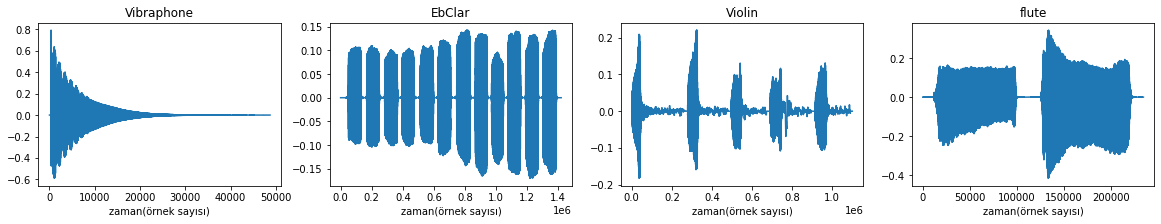

In [6]:
# Essentia kütüphanesi ses kaydını farklı örnekleme frekanslarında okumaya imkan tanıyor
# örnekleme frekansı olarak 44100Hz (audio-CD standardı) kullanalım
fs = 44100

enstruman_sayisi = len(enstruman_dosyalari.keys())
print('Örnek dalga formu çizimi')
plt.figure(1, figsize=(5 * enstruman_sayisi, 3))
dosya_endeksi = 0  # klasörlerdeki ilk örnekleri kullanalım
for i, enstruman in enumerate(enstruman_dosyalari.keys()):
    ornek_dosya = enstruman_dosyalari[enstruman][dosya_endeksi]
    # Ses kaydının dosyadan ses dizisine okunması
    ses = ess.MonoLoader(filename=ornek_dosya, sampleRate=fs)()
    # Çizim oluşturan kod satırları
    plt.subplot(1, enstruman_sayisi, (i+1))
    plt.plot(ses)
    plt.title(enstruman)
    plt.xlabel('zaman(örnek sayısı)')

Şekil 7.3: Veri örnekleri

Veriden bir dizi örnek dinlemekte fayda var. 

In [7]:
# Vibrafon klasöründeki ilk kayıt
IPython.display.Audio(
    ess.MonoLoader(
        filename=enstruman_dosyalari['Vibraphone'][0],
        sampleRate=fs)(),
    rate=fs)

In [8]:
# Flüt klasöründeki ilk kayıt
IPython.display.Audio(
    ess.MonoLoader(
        filename=enstruman_dosyalari['flute'][0],
        sampleRate=fs)(),
    rate=fs)

Bazı kayıtlarda tek nota kaydı varken bazılarında birden fazla nota kaydı var. Her bir notayı bölütleyip veri örneklerimiz olarak kullanalım.

Bölütleme işlemi için sessizlik kısımlarını tespit etmemiz gerekiyor. Bunun için sinyali küçük kesitlere bölüp her bir kesitin sessizlik olup olmadığına karar vermeliyiz. Bu işlem için bölütlerin enerjilerini belirlediğimiz bir eşik değeri ile kıyaslayabiliriz.

### Ham veri ön işleme: Bölütleme ve normalizasyon işlemleri 

Verinin yapısına, içeriğine ve etiketlerine bağlı olarak yapılması gereken birçok işlem olabilir. Altta önce bölütleme, sonra da genlik normalizasyonu işlemlerini ele alacağız.

In [9]:
# Ham veri ön işleme parametrelerinin tanımlanması

# kayıttan alınacak kesit uzunluğu (örnek sayısı cinsinden)
pencere_boyutu = 4096 * 4
# ardışık kesitler arası uzaklık (örnek sayısı cinsinden)
kaydirma_miktari = 4096 * 2
enerji_esik_orani = 0.01
# Birden fazla paramete kullanırken bu parametreleri tek bir sözlük içerisine
# yerleştirip kullanmak daha anlaşılır bir kod yazmamıza yardım edebilir
parametreler = {
    'fs': fs,
    'pencere_boyutu': pencere_boyutu,
    'kaydirma_miktari': kaydirma_miktari,
    'enerji_esik_orani': enerji_esik_orani
}

In [10]:
def dosya_bolutle(dosya_ismi, parametreler):
    '''
    Enerji eşik değeri kullanarak kaydın sessiz bölgelerinden bölünmesini 
    sağlayacak sınırları tespit eder. Öncelikle kayıt küçük parçalara bölünerek
    her kesit için enerji hesaplanmakta ardından bu enerji değerlerinin eşik
    değeriyle karşılaştırılması sonucu kesitin sesli mi sessiz mi olduğuna karar
    verilmektedir. Bu bilgi bolut_karar_fonk içerisinde 0 ve 1 değerleriyle 
    belirtilmektedir. 0-1 ve 1-0 geçişleri ise kayıtların sınırlarını bulmakta
    kullanılmakta, bunun için bolut_karar_fonk'nun türevi işlenmektedir
    '''
    ses = ess.MonoLoader(filename=dosya_ismi, sampleRate=fs)()
    enerjiler = []  # kesitlerin enerji değerlerini bir listede tutacağız
    # Pencereleme ve her veri penceresi için enerji hesabı
    for frame in ess.FrameGenerator(
            ses,
            frameSize=pencere_boyutu,
            hopSize=kaydirma_miktari,
            startFromZero=True):
        enerjiler.append(ess.Energy()(frame))
    # listeden numpy-array'e dönüştürme:
    # bu adım diziler üzerinde alttaki işlemleri yapabilmek için gerekli
    enerjiler = np.array(enerjiler)
    # Genlik normalizasyonu
    enerjiler = enerjiler / np.max(enerjiler)

    # Enerji esik oranini kullanarak bolutleme sınırlarının belirlenmesi
    bolut_karar_fonk = np.zeros_like(enerjiler)
    # sessiz kesitler 0, sesli kesitler 1 olarak atanıyor
    bolut_karar_fonk[enerjiler > enerji_esik_orani] = 1
    # Fark fonksiyonu kullanacağımız için başa 0 ekliyoruz
    bolut_karar_fonk = np.insert(bolut_karar_fonk, 0, 0)
    fark_fonksiyonu = np.diff(bolut_karar_fonk)
    # Baslangic endeksleri: 0'dan 1'e geçiş
    baslangic_endeksleri = np.nonzero(fark_fonksiyonu > 0)[
        0] * kaydirma_miktari
    # Bitis endeksleri: 1'den 0'a geçiş
    bitis_endeksleri = np.nonzero(fark_fonksiyonu < 0)[
        0] * kaydirma_miktari
    return (ses, enerjiler, bolut_karar_fonk,
            baslangic_endeksleri, bitis_endeksleri)

Her enstrüman için 3 örnek dosyada bölütleme işlemini kontrol için sınırları ses verileriyle beraber çizdirelim

Bölütleme işlemi: örnek dosyalar


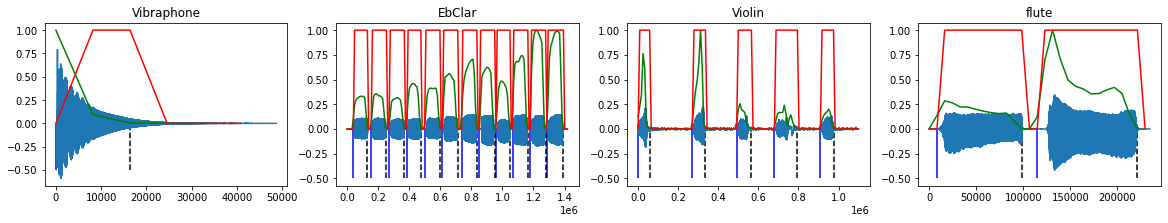

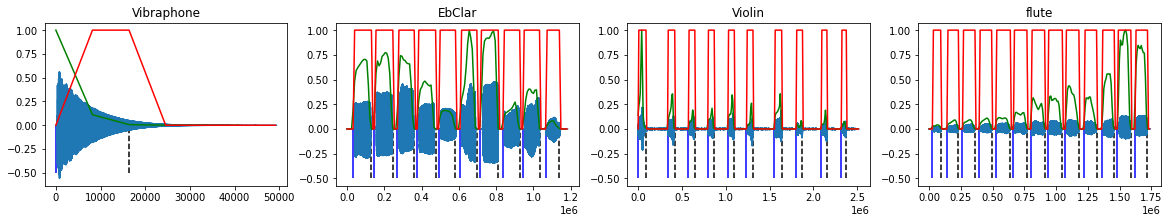

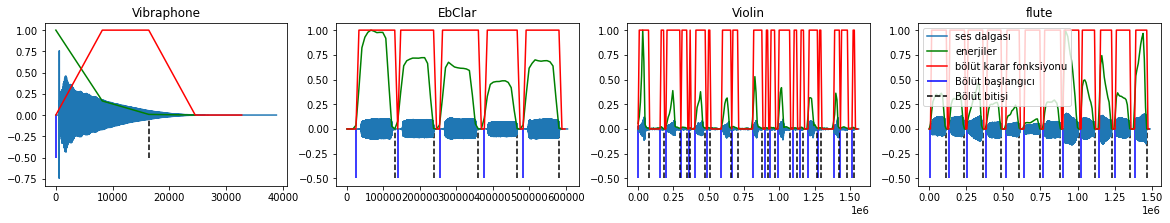

In [11]:
enstruman_sayisi = len(enstruman_dosyalari)
print('Bölütleme işlemi: örnek dosyalar')

ornek_dosya_sayisi = 3
for dosya_endeksi in range(ornek_dosya_sayisi):
    plt.figure(dosya_endeksi, figsize=(5 * enstruman_sayisi, ornek_dosya_sayisi))
    for i, enstruman in enumerate(enstruman_dosyalari.keys()):
        ornek_dosya = enstruman_dosyalari[enstruman][dosya_endeksi]
        (ses, enerjiler, bolut_karar_fonk, baslangic_endeksleri,
         bitis_endeksleri) = dosya_bolutle(ornek_dosya, parametreler)
        # Çizimlerin oluşturulması
        plt.subplot(1, enstruman_sayisi, (i+1))
        plt.title(enstruman)
        plt.plot(ses, label='ses dalgası')
        plt.plot(np.arange(enerjiler.size) * kaydirma_miktari,
                 enerjiler, 'g', label='enerjiler')
        plt.plot(np.arange(bolut_karar_fonk.size) * kaydirma_miktari,
                 bolut_karar_fonk, 'r', label='bölüt karar fonksiyonu')
        plt.vlines(baslangic_endeksleri, ymin=-0.5, ymax=0,
                   colors='b', linestyles='solid', label='Bölüt başlangıcı')
        plt.vlines(bitis_endeksleri, ymin=-0.5, ymax=0, colors='k',
                   linestyles='dashed', label='Bölüt bitişi')

plt.legend(loc='best')

Şekil 7.4: Bölütleme işleme sonucu örnekleri (otomatik bulunan sınırlar sıfır değerinden aşağıya doğru inen dikitlerle gösterilmiştir)

Bölütleme sınırları makul görünüyor. Şimdi tanımladığımız fonksiyonu kullanarak:
* Dosyalarda bölütleme işlemini yapalım 
* Her bölütü genlik normalizasyonuna tabi tutup ayrı bir dosyaya kaydedelim

Bölütler için ayrı bir alt klasör `segments` oluşturup dosyaları onun içerisine yerleştireceğiz.

In [12]:
bolutler_klasoru = os.path.join(veri_klasoru, 'segments')
if not os.path.exists(bolutler_klasoru):  # klasör yok ise oluşturalım
    os.mkdir(bolutler_klasoru)

bolut_dosyalari = []
for enstruman, dosyalar in enstruman_dosyalari.items():
    dosya_sayaci = 0
    for ornek_dosya in dosyalar:
        (ses, enerjiler, bolut_karar_fonk, baslangic_endeksleri,
         bitis_endeksleri) = dosya_bolutle(ornek_dosya, parametreler)
        # Bölütleme, normalizasyon ve dosyaya yazma
        for baslangic, bitis in zip(baslangic_endeksleri, bitis_endeksleri):
            # bölütlemede hata sonucu çok kısa kesitler oluşabilir,
            # sadece 1/3 saniye'den uzun olanları tutalım
            if bitis - baslangic > fs/3:
                ses_seg = ses[baslangic: bitis]
                # Küçük bir sessizlik bolumu bolut olarak alınmış olabilir,
                # enerjisini kontrol ederek düşükse dışarıda bırakalım
                if np.max(np.abs(ses_seg)) > 0.05:
                    # Genlik normalizasyonu
                    ses_seg = ses_seg / np.max(np.abs(ses_seg))
                    dosya_ismi = os.path.join(
                        bolutler_klasoru, 
                        enstruman + '_' + str(dosya_sayaci) + '.wav')
                    ess.MonoWriter(filename=dosya_ismi,
                                   format='wav', sampleRate=fs)(ses_seg)
                    dosya_sayaci += 1
                    bolut_dosyalari.append(dosya_ismi)

print(len(bolut_dosyalari), 'adet bölütlenmiş dosya oluşturuldu')

193 adet bölütlenmiş dosya oluşturuldu


In [13]:
# Ihtiyaç duyarsanız (yanlış işlemle çok sayıda dosya oluşturduysanız)
# bu fonksiyonu bir klasör içerisindeki tüm dosyaları silmek için kullanabilirsiniz
def klasoru_temizle(ana_klasor):
    '''Verilen klasordeki tum dosyalari siler'''
    for root, dirs, files in os.walk(ana_klasor):
        for dosya in files:
            dosya_ismi = os.path.join(root, dosya)
            os.remove(dosya_ismi)
            print(dosya_ismi, 'silindi')

# klasoru_temizle(bolutler_klasoru)

Bölütlenmiş dosyalar oluşturuldu, `data/instrument/segments` klasörünü kontrol edebilirsiniz

## Öznitelik çıkarımı

Şimdi bölütlenmiş her bir ses dosyası için öznitelikler hesaplayıp kategori/etiket/enstrüman bilgisi ile beraber tek bir veri dosyası içerisine yazabiliriz. Öznitelik çıkarımı için Essentia kütüphanesinin [MusicExtractor](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) fonksiyonunu kullanacağız. 

Öncelikle tek bir dosya için çalıştırıp verdiği çıktıyı inceleyelim:

In [14]:
import essentia.standard as es

dosya = bolut_dosyalari[0]  # listeden ilk dosyayı kullanalım
oznitelikler, oznitelik_pencereler = es.MusicExtractor(
    lowlevelSilentFrames='drop',
    lowlevelFrameSize=2048,
    lowlevelHopSize=1024,
    lowlevelStats=['mean', 'stdev'])(dosya)

Essentia-MusicExtractor çok sayıda temel özniteliği hızlı bir şekilde hesaplayıp çıktı olarak verir. Biz, kodumuzun ve gösterimlerimizin kısa ve anlaşılır olması için, bunların içerisinde tek bir skaler değerle temsil edilen düşük seviye (low-level) öznitelikleri kullanacağız ve diğer öznitelikleri dışarıda bırakacağız. 

In [15]:
skaler_oznitelikler = [
    descriptor for descriptor in oznitelikler.descriptorNames()
    if 'lowlevel' in descriptor and isinstance(oznitelikler[descriptor], float)
]
print('Kullanılacak oznitelikler:\n' + '\n'.join(skaler_oznitelikler))

Kullanılacak oznitelikler:
lowlevel.average_loudness
lowlevel.barkbands_crest.mean
lowlevel.barkbands_crest.stdev
lowlevel.barkbands_flatness_db.mean
lowlevel.barkbands_flatness_db.stdev
lowlevel.barkbands_kurtosis.mean
lowlevel.barkbands_kurtosis.stdev
lowlevel.barkbands_skewness.mean
lowlevel.barkbands_skewness.stdev
lowlevel.barkbands_spread.mean
lowlevel.barkbands_spread.stdev
lowlevel.dissonance.mean
lowlevel.dissonance.stdev
lowlevel.dynamic_complexity
lowlevel.erbbands_crest.mean
lowlevel.erbbands_crest.stdev
lowlevel.erbbands_flatness_db.mean
lowlevel.erbbands_flatness_db.stdev
lowlevel.erbbands_kurtosis.mean
lowlevel.erbbands_kurtosis.stdev
lowlevel.erbbands_skewness.mean
lowlevel.erbbands_skewness.stdev
lowlevel.erbbands_spread.mean
lowlevel.erbbands_spread.stdev
lowlevel.hfc.mean
lowlevel.hfc.stdev
lowlevel.loudness_ebu128.integrated
lowlevel.loudness_ebu128.loudness_range
lowlevel.loudness_ebu128.momentary.mean
lowlevel.loudness_ebu128.momentary.stdev
lowlevel.loudness_ebu1

Tüm dosyalar için öznitelik çıkarımı işleminin yapıp, skaler öznitelikleri alıp elde ettiğimiz tüm verileri `data.csv` isimli bir dosyaya yazalım. 

Bu tercihimiz şuna dayanıyor: birçok makine öğrenmesi veri kümesi satırların örnekleri, sütunların öznitelikleri içerdiği tablolar şeklinde saklanıp paylaşılıyor. Örnekler için bakınız: [Kaggle verileri](https://www.kaggle.com/), [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). 

***Çalıştığımız alanda kullanılan formatlarla uyumlu format tercih etmek, araç ve veri paylaşımını, bu sayede başka araştırmacılarla işbirliğini kolaylaştıracaktır.***

Yaygın tercih son kolonda etiket bilgisinin bulunması olduğu için biz de öyle yapacağız.

In [16]:
# Her dosya için oznitelik çıkarımı ve data.csv dosyasına yazım işlemi
# data.csv dosyasında her satır bir örneği temsil edecek,
# önce öznitelikleri, en sonda da sınıf bilgisini içerecek
veri_dosyasi = os.path.join(bolutler_klasoru, 'data.csv')
dosya_sayaci = 0
with open(veri_dosyasi, 'w') as yazici:
    # İlk kolon olarak öznitelik isimlerini,
    # son kolon olarak sınıf bilgisini temsilen 'enstruman' yazalım
    yazilacak_satir = ','.join(
        skaler_oznitelikler + ['enstruman']).replace('lowlevel.', '') + '\n'
    yazici.write(yazilacak_satir)
    for dosya in bolut_dosyalari:
        if '.wav' in dosya:
            dosya_sayaci += 1
            if dosya_sayaci % 20 == 0:  # 20 dosyada bir ekrana bilgi yazdır
                print(dosya_sayaci,
                      'adet dosya işlendi, işlenmekte olan dosya: ', dosya)
            oznitelikler, oznitelik_pencereler = es.MusicExtractor(
                lowlevelSilentFrames='drop',
                lowlevelFrameSize=2048,
                lowlevelHopSize=1024,
                lowlevelStats=['mean', 'stdev'])(dosya)
            secilmis_oznitelikler = [
                oznitelikler[oznitelik_ismi]
                for oznitelik_ismi in skaler_oznitelikler]
            # sınıf bilgisinin dosya isminden elde edilmesi
            enstruman = dosya.split('/')[-1].split('_')[0].lower()
            yazilacak_satir = str(secilmis_oznitelikler)[
                1:-1] + ',' + enstruman + '\n'
            yazici.write(yazilacak_satir)
print(dosya_sayaci, 'adet dosya işlendi')

20 adet dosya işlendi, işlenmekte olan dosya:  instrument/segments/Vibraphone_19.wav
40 adet dosya işlendi, işlenmekte olan dosya:  instrument/segments/Vibraphone_39.wav
60 adet dosya işlendi, işlenmekte olan dosya:  instrument/segments/EbClar_17.wav
80 adet dosya işlendi, işlenmekte olan dosya:  instrument/segments/EbClar_37.wav
100 adet dosya işlendi, işlenmekte olan dosya:  instrument/segments/Violin_18.wav
120 adet dosya işlendi, işlenmekte olan dosya:  instrument/segments/Violin_38.wav
140 adet dosya işlendi, işlenmekte olan dosya:  instrument/segments/Violin_58.wav
160 adet dosya işlendi, işlenmekte olan dosya:  instrument/segments/flute_2.wav
180 adet dosya işlendi, işlenmekte olan dosya:  instrument/segments/flute_22.wav
193 adet dosya işlendi


### Özniteliklerin incelenmesi ve ön işlemesi

Dosyalar için hesaplanan bütün öznitelikler, her biri bir satırda olacak şekilde tek bir dosyaya yazıldı: `data.csv`. Bu temsilde kolonlar öznitelikleri, satırlar da her bir örneği/dosyayı temsil etmekte. Bu, makine öğrenmesi verilerinde sıkça kullanılan bir düzendir.   

Verileri yükleyip incelemeye başlayalım. Bunun için [`pandas`](https://pandas.pydata.org/docs/getting_started/index.html) kütüphanesi kullanacağız. 

In [17]:
import pandas as pd

# Verilerin okunması
tablo = pd.read_csv(veri_dosyasi)
# Verinin baş kısmının görüntülenmesi
tablo.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,enstruman
0,0.990684,24.955116,3.647825,0.536830,0.119398,289.010223,132.418945,4.110642,6.952480,0.616870,...,217.607498,6.032936,1.900585,3004128.250,4737389.5,3.668774,2.720361,0.042567,0.007204,vibraphone
1,0.990684,26.435593,1.601422,0.636219,0.147186,1055.020752,482.626892,14.076157,10.212609,0.358621,...,70.797035,9.389044,2.429082,1778017.125,2592701.5,3.698664,2.426341,0.039608,0.009589,vibraphone
2,0.990684,23.885178,5.053813,0.520682,0.141888,262.656921,122.478897,9.697014,4.188370,1.247010,...,440.509766,7.501504,2.710040,3043914.750,4758099.5,2.022717,1.253518,0.025333,0.019186,vibraphone
3,0.990684,23.565981,4.597108,0.425580,0.135100,59.750126,54.249290,-6.715064,3.709975,8.052089,...,1236.714355,5.807158,2.171984,2031814.125,1917425.5,5.219349,3.358985,0.101094,0.015830,vibraphone
4,0.990684,26.508205,1.411997,0.623173,0.146127,2803.306152,1543.358643,29.534590,15.452468,0.362204,...,31.129938,9.847502,3.322612,2524568.750,5650975.5,2.772293,2.281401,0.033519,0.012665,vibraphone


Kolonların doğru şekilde öznitelik adlarıyla isimlendirildiğini (ilk 84 kolon), son kolonda kategori/sınıf bilgisi olduğunu görüyoruz.

Bir veri tablosu yüklediğinizde işlemlere başlamadan verinin içerisinde `NaN` değerler olup olmadığını kontrol etmemizde fayda var. Eğer `NaN` değerler varsa bunları temizlememiz lazım. Bunun için kullanabileceğimiz stratejilere diğer bölümlerde değineceğiz. 

In [18]:
# .isnull()'ın döndürdüğü True/False değerleri içeren 
# matrisin toplamı sıfırdan farklı ise True (yani NaN) değer vardır
print(tablo.isnull().sum().sum())

0


**Gözlem:** Nan değer yok, devam edebiliriz ...

Verilerin öznitelik uzayında nasıl dağıldığını incelemek de çok faydalı olacaktır. İki örnek çizim görelim

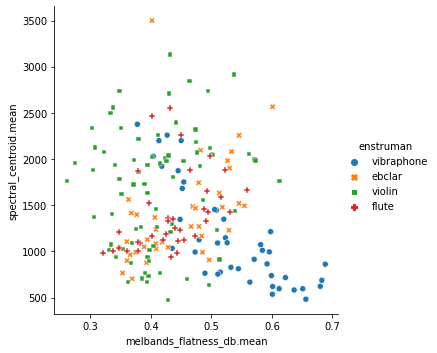

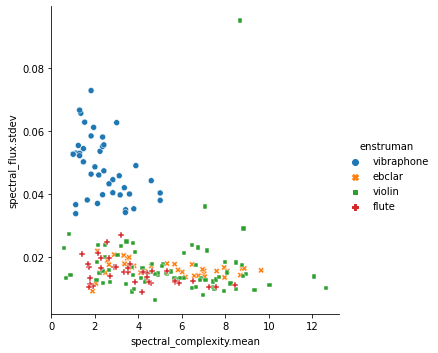

In [19]:
import seaborn as sns
sns.relplot(x='melbands_flatness_db.mean', y='spectral_centroid.mean',
            hue='enstruman', style='enstruman', data=tablo)
sns.relplot(x='spectral_complexity.mean', y='spectral_flux.stdev',
            hue='enstruman', style='enstruman', data=tablo)

Şekil 7.5: İki boyutlu öznitelik uzayında verilerin görselleştirilmesi

Bu tür grafikler oluşturup incelerken amacımız verinin hangi eksenlerde/özniteliklerde birbirinden rahat ayrılabileceğini öngörmek. Örneğin üstteki grafikte `spectral_flux_stdev` özniteliğinin vibrafon örneklerini diğerlerinden ayırmada faydalı olacağını öngörebiliyoruz; o eksende veri dağılımında bir ayrılma gözlenebiliyor. Öznitelik uzayında veriler ne kadar iç içe ise o kadar zor bir otomatik sınıflandırma problemi ile yüzyüzeyiz demektir. 

Benzer grafikleri son 6 öznitelik üzerinden olası tüm ikililer için çizdirelim ve farklı kategorilerdeki verilerin bir arada gruplanıp gruplanmadığını gözleyelim. 

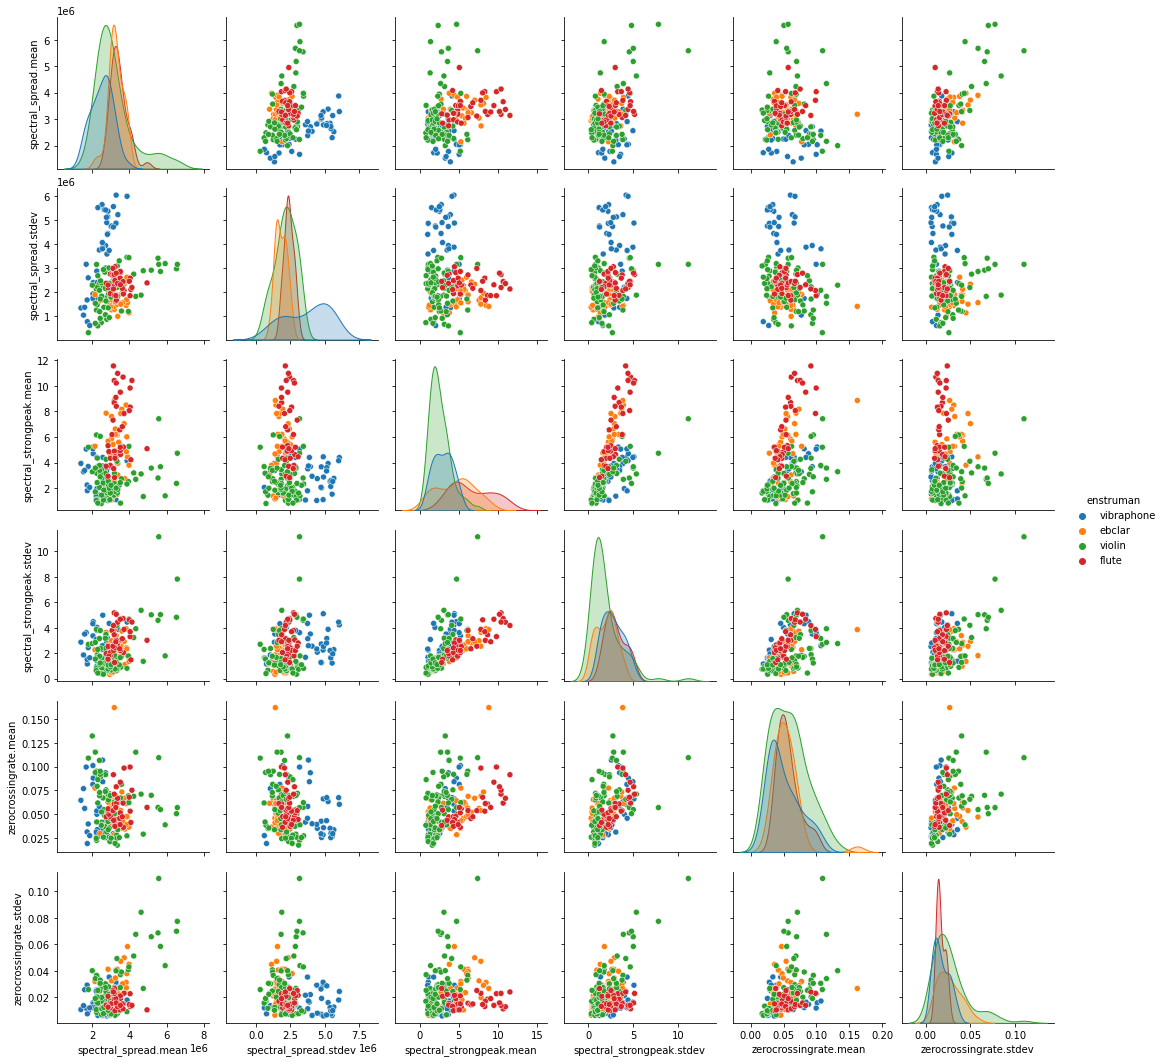

In [20]:
sns.pairplot(tablo.iloc[:, -7:], hue='enstruman')

Şekil 7.6: İki boyutlu öznitelik uzayında verilerin görselleştirilmesi. (Diyagonalde iki boyut için de aynı öznitelik kullanıldığı için dağılım grafikleri sunulmaktadır.)

Bir sonraki adımda özniteliklerin istatistiksel özelliklerini inceleyelim. 

In [21]:
# Veriye dair "Descriptive statistics"
tablo.describe()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,193.000000,193.000000,193.000000,193.000000,1.930000e+02,1.930000e+02,193.000000,193.000000,193.000000,193.000000
mean,0.986378,18.737075,3.533494,0.430367,0.102611,283.950441,628.912498,3.632873,4.466255,9.637900,...,1540.656583,760.391840,3.335840,1.303501,3.089807e+06,2.443487e+06,3.835344,2.347946,0.055322,0.022904
std,0.006414,4.673740,1.205451,0.079073,0.040251,999.686998,2476.937780,6.138561,7.892060,6.017747,...,710.809230,561.415954,1.765828,0.898021,8.214676e+05,1.145174e+06,2.399718,1.485965,0.023783,0.015384
min,0.944595,7.485431,1.186291,0.260509,0.030590,-1.065718,0.525588,-7.482044,0.199631,0.358621,...,448.608398,5.137959,0.950112,0.320255,1.384233e+06,3.002179e+05,0.805183,0.336106,0.017263,0.005875
25%,0.982277,15.009152,2.775762,0.367775,0.072194,5.696008,11.835285,0.806964,1.204419,5.727079,...,1003.193909,388.462433,2.298174,0.673137,2.620608e+06,1.742066e+06,1.990636,1.165608,0.038632,0.012656
50%,0.990684,18.754087,3.416813,0.422366,0.098511,11.744920,29.479961,1.685290,2.010876,8.556026,...,1378.125000,627.297546,2.775611,0.956109,3.019486e+06,2.246092e+06,3.288788,2.212921,0.051336,0.018890
75%,0.990684,22.895193,4.060770,0.488050,0.125469,57.957664,69.372818,3.784954,3.243660,13.196887,...,2060.806641,990.779724,3.632514,1.734663,3.373299e+06,2.829660e+06,5.056057,3.150032,0.067383,0.027325
max,0.990684,26.508205,8.019904,0.636219,0.264137,9113.940430,22528.574219,33.979153,56.715878,26.559134,...,4256.789551,2818.890381,9.847502,5.231009,6.583575e+06,6.047924e+06,11.551766,11.142886,0.162156,0.109800


**Gözlem:** Özniteliklerin dinamik aralıkları çok farklı, normalize etmeliyiz. Bazı öznitelikler (örneğin `average_loudness`) bu problem için kullanılması anlamsız veya hemen hemen sabit değerler içeriyor. Varyansı düşük öznitelikleri dışarıda bırakabiliriz. 


Varyansı ortalama değerinin binde birinin altında olan kolonları dışarıda bırakalım.


In [22]:
dusuk_varyansli_oznitelikler = []
for kolon in tablo.columns:
    if kolon != 'enstruman':
        varyans = np.var(tablo[kolon])
        if varyans < np.mean(tablo[kolon]) * 0.001:
            print(
                kolon, ':\tvaryans =', np.var(tablo[kolon]),
                'ortalama =', np.mean(tablo[kolon]))
            dusuk_varyansli_oznitelikler.append(kolon)

print('Öznitelikler atılmadan önceki boyut:', tablo.shape)
tablo = tablo.drop(columns=dusuk_varyansli_oznitelikler)
skaler_secilmis_oznitelikler = list(tablo.columns)[:-1]
print('Öznitelikler atıldıktan sonraki boyut:', tablo.shape)

average_loudness :	varyans = 4.0925312732997144e-05 ortalama = 0.986378416187405
silence_rate_20dB.mean :	varyans = 3.3036432587549685e-06 ortalama = 0.9998688265449642
silence_rate_30dB.mean :	varyans = 7.037403313105313e-05 ortalama = 0.9991705213803701
spectral_decrease.stdev :	varyans = 6.4385830677640396e-18 ortalama = 3.731881534079091e-09
spectral_rms.mean :	varyans = 1.943454793577788e-06 ortalama = 0.004050059194575192
spectral_rms.stdev :	varyans = 2.65605378621194e-07 ortalama = 0.0019590600805086383
Öznitelikler atılmadan önceki boyut: (193, 85)
Öznitelikler atıldıktan sonraki boyut: (193, 79)


### Özniteliklerin ön işlemesi


Sınıflandırıcı modelimizi eğitmeye başlamadan önce öznitelik verimiz üzerinde uygulayabileceğimiz ön işleme adımlarına değinelim.


#### Normalizasyon

Öznitelik normalizasyonu makine öğrenmesi modelinin eğitilebilmesi için gerekli ön adımlardan birisidir. Özniteliklerin normalize edilmemesi (öznitelikler arasında büyük boyut farklılıklarının olması) optimizasyon sürecinde modelin iç parametrelerinin iyileştirilmesini zorlaştırmaktadır. Verimize baktığımızda örneğin `melbands_kurtosis.mean` ile `melbands_flatness_db.mean` büyüklükleri arasında 6000 kat civarında fark olduğunu gözlüyoruz. Öncelikle bu farklılıkları gidermeliyiz.


Çok farklı normalizasyon stratejileri mevcuttur ve kullanılan modele uygun bir strateji tercih edilmelidir. Bu konuda kısa bir özet incelemek isterseniz: [Normalization Techniques At A Glance](https://developers.google.com/machine-learning/data-prep/transform/normalization) ya da [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py) sayfalarını inceleyebilirsiniz. Bu bölümde yaygın kullanılan yöntemlerden birisi olan "Standard scaling"i `sklearn` kütüphanesinde gerçeklendiği şekliyle kullanacağız. 

In [23]:
# sklearn kütüphanesinin preprocessing araçları ile normalizasyon
from sklearn import preprocessing

yeni_tablo = tablo.copy()
normalizasyon_araci = preprocessing.StandardScaler()
# aracının egitimi ve uygulanması (son kolon hariç)
yeni_tablo.iloc[:, :-1] = normalizasyon_araci.fit_transform(
    tablo.iloc[:, :-1].values)
yeni_tablo.describe()

,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,...,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
count,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,193.000000,193.000000,193.000000,1.930000e+02,1.930000e+02,1.930000e+02,...,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,193.000000,1.930000e+02,1.930000e+02,1.930000e+02
mean,3.497490e-16,-7.363137e-17,-5.062157e-16,-7.363137e-17,0.000000,0.000000,0.000000,1.840784e-17,1.380588e-17,-1.196510e-16,...,1.288549e-16,-9.203921e-18,3.681569e-17,-5.522353e-17,-1.656706e-16,-3.681569e-17,0.000000,1.840784e-17,7.363137e-17,-3.497490e-16
std,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601,1.002601,1.002601,1.002601e+00,1.002601e+00,1.002601e+00,...,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601,1.002601e+00,1.002601e+00,1.002601e+00
min,-2.413679e+00,-1.952222e+00,-2.153696e+00,-1.793942e+00,-0.285847,-0.254355,-1.815381,-5.420284e-01,-1.545996e+00,-1.593183e+00,...,-1.540341e+00,-1.348765e+00,-1.354567e+00,-1.097750e+00,-2.081652e+00,-1.876435e+00,-1.266000,-1.357416e+00,-1.604452e+00,-1.109786e+00
25%,-7.997059e-01,-6.302225e-01,-7.936345e-01,-7.576492e-01,-0.279065,-0.249777,-0.461551,-4.143808e-01,-6.515713e-01,-6.398669e-01,...,-7.580944e-01,-6.642076e-01,-5.891650e-01,-7.037727e-01,-5.726574e-01,-6.140950e-01,-0.770718,-7.977397e-01,-7.035951e-01,-6.678179e-01
50%,3.649523e-03,-9.704619e-02,-1.014457e-01,-1.021422e-01,-0.272999,-0.242635,-0.318095,-3.119293e-01,-1.802482e-01,-1.189795e-01,...,-2.292518e-01,-2.376855e-01,-3.180864e-01,-3.878472e-01,-8.582672e-02,-1.728193e-01,-0.228351,-9.110318e-02,-1.680577e-01,-2.615907e-01
75%,8.919907e-01,4.385478e-01,7.313823e-01,5.693651e-01,-0.226651,-0.226487,0.024839,-1.553174e-01,5.929533e-01,4.127230e-01,...,7.336749e-01,4.114366e-01,1.684453e-01,4.813732e-01,3.460025e-01,3.380943e-01,0.510013,5.411782e-01,5.084298e-01,2.881321e-01
max,1.667046e+00,3.731449e+00,2.610067e+00,4.023387e+00,8.855727,8.864420,4.956407,6.637749e+00,2.819201e+00,4.780104e+00,...,3.831122e+00,3.676155e+00,3.697188e+00,4.384887e+00,4.264142e+00,3.155688e+00,3.223917,5.934067e+00,4.503764e+00,5.663165e+00


**Gözlem:** Öznitelikler normalize edildi. Şimdi tablomuzu makine öğrenmesi araçlarının kabul ettiği matrislere dönüştürebiliriz

**ÖNEMLİ:** Problemin ve verinin doğasına bağlı olarak özniteliklere uygulanması gereken çok sayıda işlem olabilir. Örneğin boyut azaltma işlemlerine ihtiyaç duyulabilir. Defterimizin karmaşıklığını artırmamak için ön işlemeyi normalizasyon ile sınırlı tuttuk.  

#### Veri örnek sayısını dengeleme

Şimdi elimizdeki veri kümesinin kategorilere düşen örnek sayıları açısından dengeli olup olmadığına bakalım:

In [24]:
yeni_tablo.enstruman.value_counts()

violin        76
vibraphone    42
ebclar        39
flute         36
Name: enstruman, dtype: int64

**Gözlem**: Verilerimiz kategorilere ait örnek sayıları açısından dengeli değil, bazı kategorilerde diğerlerine göre daha fazla sayıda örnek var. Bir dengeleme işlemi uygulamakta fayda var. Dengeli olmayan veri kümeleri üzerinde de makine öğrenmesi testleri tasarlayabiliriz. Fakat örneği karmaşıklaştırmamak için bu konuyu bu bölümde ele almayacağız.

Kategorilere ait veri sayılarının dengelenmesi için farklı stratejiler uygulanabilir. Sık kullanılan iki yöntem alttaki figürlerde özetlenmiştir. Fazla olan örnekleri atarak denge kurulmasına "undersampling" ismi verilir ve bu bölümde bu teknik kullanılmıştır. Diğer bir alternatif az örnek bulunan kategoriye yeni örnekleri ya varolan örnekleri doğrudan kopyalayarak, ya da kategorisini bozmadan değiştirip kopyalayarak dengeyi sağlamaktır. 



![Balancing](https://miro.medium.com/max/725/0*FeIp1t4uEcW5LmSM.png)

Şekil 7.7: Veri dengeleme yöntemleri

En az sayıda örnek içeren küme flüt kümesi (36 örnek). Her kümede rasgele seçilmiş 36 örnek tutup gerisini dışarıda bırakarak örnek kümemizi dengeleyelim. 

In [25]:
en_az_sayi = yeni_tablo.enstruman.value_counts()['flute']
violin_tablo = yeni_tablo[yeni_tablo.enstruman ==
                          'violin'].sample(n=en_az_sayi, random_state=0)
vibraphone_tablo = yeni_tablo[yeni_tablo.enstruman ==
                              'vibraphone'].sample(n=en_az_sayi, random_state=0)
ebclar_tablo = yeni_tablo[yeni_tablo.enstruman ==
                          'ebclar'].sample(n=en_az_sayi, random_state=0)
flute_tablo = yeni_tablo[yeni_tablo.enstruman == 'flute']
# Oluşturduğumuz küçültülmüş kümeleri birleştirelim
yeni_tablo = pd.concat(
    [ebclar_tablo, flute_tablo, violin_tablo, vibraphone_tablo])
# Dağılıma tekrar bakabiliriz
yeni_tablo.enstruman.value_counts()


ebclar        36
flute         36
violin        36
vibraphone    36
Name: enstruman, dtype: int64

## Otomatik sınıflandırıcı eğitimi ve testi


### Öznitelikler ve etiketler için matrislerin formatlanması

**Öznitelikler ("inputs", `X`) ve etiketler ("outputs", `y`) için matrislerin formatlanması**

Şimdi sınıflandırıcıların giriş-çıkış formatlarına uygun matrisleri hazırlayabiliriz. Giriş-çıkış formatlarını öğrenmek için `scikit-learn` dokümantasyonunu veya [örneklerini](https://scikit-learn.org/stable/tutorial/index.html) inceleyebilirsiniz.




In [26]:
# Son kolon dışındaki kolonlar öznitelikleri içeriyor
# girdi matrisimiz (X) bu kolonlardan oluşacak.
X = yeni_tablo.iloc[:, :-1].values
# Çıktılar etiket bilgilerini içeriyor olacak. Bu bilgiler son kolonda bulunuyor.
# Sınıflandırıcı eğitiminde kullanabilmek için enstrüman ismi şeklinde
# saklanan bu bilgileri sayısal bilgilere dönüştürmemiz gerekli.

# enstruman verisini kategorik tür veriye dönüştürelim
yeni_tablo.enstruman = pd.Categorical(yeni_tablo.enstruman)
# her kategoriyi bir tam sayı olarak temsil edelim
y = np.array(yeni_tablo.enstruman.cat.codes)

print('İlk örneğin öznitelikleri:', X[0])
print('İlk örneğin etiketi:', y[0])

# Değerler: ebclar: 0, flute: 1, vibraphone: 2, violin: 3
print('Tüm etiket bilgileri:', y)

İlk örneğin öznitelikleri: [-0.4414347  -1.06871023 -0.59960443 -0.91132223 -0.27606381 -0.23232526
 -0.45138147 -0.22668588 -0.1121437  -0.28435331 -0.06325772 -0.14552512
  0.25726921 -0.32207451 -0.41512103 -0.9939726  -0.17804692 -0.50878155
 -0.86485942 -0.54866474 -1.31789831 -0.09244342  0.09912435  0.81744038
 -0.2809432   0.60497683  0.          0.63874899 -0.11270043  0.76832921
  0.         -1.26799778  0.1019887  -0.71195111 -1.04006459 -0.20598719
 -0.20330652 -0.29274    -0.23560128  0.14261715 -0.52647709  0.79948739
 -0.50821474 -0.07216878 -0.10154773 -0.64453122 -0.55969605 -0.68663291
  0.13648369  0.85922032  0.47382536 -1.52409208  1.50343256  0.23421587
 -0.40555442 -0.30418492 -0.17158886 -0.12661445  1.23797144  0.47120161
  0.44908563 -0.14400193  0.67301449 -0.41980772 -1.08669669 -0.58897149
 -0.45517733 -0.66206745 -0.85835363 -0.74775545 -0.29746722 -0.78064147
  0.40118828 -0.15235071  0.73555497 -0.07508544 -0.41698906 -0.81288885]
İlk örneğin etiketi: 0


### Verinin eğitim ve test alt-kümelerine bölünmesi

Veri setimizin bir kısmını sınıflandırıcıyı eğitirken, başka bir kısmını da eğittiğimiz sınıflandırıcıyı test etmek için kullanacağız. 

<img src = "https://developers.google.com/machine-learning/crash-course/images/PartitionTwoSets.svg" width=500 />


In [27]:
# sklearn kütüphanesi train_test_split fonksiyonu ile veri setinin bölünmesi
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

print('Eğitim kümesindeki öznitelikler matrisi boyutu:', X_train.shape,
      '\nEğitim kümesindeki etiket matrisi boyutu:', y_train.shape)
print('Test kümesindeki öznitelikler matrisi boyutu:', X_test.shape,
      '\nTest kümesindeki etiket matrisi boyutu:', y_test.shape)

Eğitim kümesindeki öznitelikler matrisi boyutu: (96, 78) 
Eğitim kümesindeki etiket matrisi boyutu: (96,)
Test kümesindeki öznitelikler matrisi boyutu: (48, 78) 
Test kümesindeki etiket matrisi boyutu: (48,)


### Makine öğrenmesi metodunun tanımlanması ve eğitilmesi

Şimdi bir makine öğrenmesi modeli eğitebiliriz. Bir destek vektör makinesi sınıflandırıcısı tanımlayıp eğitelim. 

In [28]:
from sklearn import svm
# tanımlama adımı
clf = svm.SVC(gamma=1 / (X_train.shape[-1] * X_train.var()), random_state=0)
# eğitim adımı
clf.fit(X_train, y_train)

SVC(gamma=0.015687177800161187, random_state=0)

### Eğitilen modelin test edilmesi

Modelimiz eğitildiğine göre test verileri üzerinden testimizi yapabiliriz. Bunun için test kümesinin özniteliklerini sınıflandırıcıya vererek etiketi tahmin etmesini isteyeceğiz. Ardından tahmin edilen bu değerler ile gerçek etiketleri karşılaştıracağız. 

In [29]:
# sınıflandırıcı aracılığyla özniteliklerden etiketlerin tahmin edilmesi
y_pred = clf.predict(X_test)

# Tahmin edilen etiketler ile gerçek etiketleri karşılaştıralım
tahmin_dogruluk_matrisi = y_test == y_pred

print(tahmin_dogruluk_matrisi)

# Verimiz dengeli olduğu için "accuracy" ölçütü sınıflandırıcımızın 
# performansını temsil eden önemli ölçütlerden birisi olarak düşünülebilir.
accuracy = np.sum(tahmin_dogruluk_matrisi)/len(tahmin_dogruluk_matrisi)
print('accuracy:', accuracy)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True]
accuracy: 0.9583333333333334


**Gözlem:** Burada gözlediğimiz değer bize sistem performansı açısından önemli bir bilgi verse de bu değeri etkileyen farkında olmadığımız faktörler olabilir. Testimizin zayıf olduğu noktaları dikkatlice düşünmeli ve sonuçla beraber bunları raporlamalıyız. Örneğin veri kümemizdeki örnek sayısı gerçek dünyayı temsil edemeyecek kadar az. Bu sebeple gerçek bir uygulamada bu sınıflandırıcının başarısının yukarıda raporlanan düzeydekinden farklı olacağını bilmeliyiz. 

**Ayrıca testlerimizde yanlılık oluşturacak önemli bir faktör var!!:** Örneklerimizi oluştururken dosyalardan parçalar aldık. Rasgele parçaları kararak yaptığımız testlerde eğitim kümesindeki ve test kümesindeki parçalar birbirlerinden farklı olmakla beraber aynı dosyalardan gelebiliyorlardı. Oysaki test kümesi ile eğitim kümesi arasında bu tür bağların olmaması gerekir. **Sizin fark ettiğiniz başka sorunlar var mı?**

**!!! İlk testte 0.9 üzeri bir sonuç elde ettiyseniz özellikle şüphelenin:**
Kodunuzu kontrol edin. Test kümenizdeki verilerin gerçek uygulama koşullarında elde edilecek verileri temsil edip etmediğini sorgulayın. Test ve eğitim kümeleri arasında olası bağları sorgulayın. 

Son adım olarak karıştırma matrisini (**confusion matrix**) çizdirip inceleyelim.

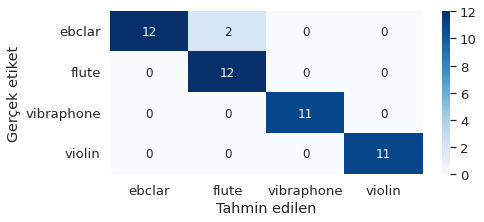

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

siniflar = np.unique(yeni_tablo.enstruman)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                        columns=siniflar, index=siniflar)
conf_mat.index.name = 'Gerçek etiket'
conf_mat.columns.name = 'Tahmin edilen'
plt.figure(figsize=(7, 3))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, cmap='Blues', annot_kws={'size': 12}, annot=True)

Şekil 7.8: Karıştırma matrisi

#### Eğittiğimiz sistemin verili bir ses dosyası üzerinde etiketleme işlemi için kullanılması

Eğitim ve test işlemlerini yaparak bir sınıflandırıcı hazırladık. Şimdi ise tasarlanmış bir sınıflandırıcının kullanım demosunu yapmak için veri kümemizdeki tüm örnekleri bu sınıflandırıcıdan geçireceğiz. 

In [31]:
# Etiket değer-isim tablosu
siniflar = {0: 'ebclar', 1: 'flute', 2: 'vibraphone', 3: 'violin'}


def enstruman_tani(dosya, skaler_oznitelik_isimleri, normalizasyon_araci, siniflar, siniflandirici):
    '''
    Verili bir ses dosyasının hangi enstrümanın kaydı olduğunu tahmin eder ve
    çıktı olarak enstrüman ismini verir
    '''
    # Dosyanın özniteliklerinin hesaplanması
    oznitelikler, oznitelik_pencereler = es.MusicExtractor(
        lowlevelSilentFrames='drop', lowlevelFrameSize=2048,
        lowlevelHopSize=1024, lowlevelStats=['mean', 'stdev'])(dosya)
    # Özniteliklerin bir alt-kümesini kullanmıştık, onları seçelim
    secilmis_oznitelikler = [oznitelikler['lowlevel.'+oznitelik_ismi]
                             for oznitelik_ismi in skaler_oznitelik_isimleri]
    # Öznitelik değerlerine normalizasyon adımında tanımlanmış oranları uygulayalım
    oranlanmis_oznitelikler = normalizasyon_araci.transform(
        np.array(secilmis_oznitelikler).reshape(1, -1))

    # Sınıflandırıcı etiketi tahmin etsin
    y_pred = siniflandirici.predict(oranlanmis_oznitelikler)

    return siniflar[y_pred[0]]


# Her bir dosyanın otomatik sınıflandırılma işlemleri
for dosya in bolut_dosyalari:
    enstruman_tahmini = enstruman_tani(
        dosya, skaler_secilmis_oznitelikler, normalizasyon_araci, siniflar, clf)

    # Çıktıyı dosya ismiyle beraber yazdıralım
    print(dosya, ' dosyası sınıflandırma sonucu: ', enstruman_tahmini)

instrument/segments/Vibraphone_0.wav  dosyası sınıflandırma sonucu:  vibraphone
instrument/segments/Vibraphone_1.wav  dosyası sınıflandırma sonucu:  vibraphone
instrument/segments/Vibraphone_2.wav  dosyası sınıflandırma sonucu:  vibraphone
instrument/segments/Vibraphone_3.wav  dosyası sınıflandırma sonucu:  vibraphone
instrument/segments/Vibraphone_4.wav  dosyası sınıflandırma sonucu:  vibraphone
instrument/segments/Vibraphone_5.wav  dosyası sınıflandırma sonucu:  vibraphone
instrument/segments/Vibraphone_6.wav  dosyası sınıflandırma sonucu:  vibraphone
instrument/segments/Vibraphone_7.wav  dosyası sınıflandırma sonucu:  vibraphone
instrument/segments/Vibraphone_8.wav  dosyası sınıflandırma sonucu:  vibraphone
instrument/segments/Vibraphone_9.wav  dosyası sınıflandırma sonucu:  vibraphone
instrument/segments/Vibraphone_10.wav  dosyası sınıflandırma sonucu:  vibraphone
instrument/segments/Vibraphone_11.wav  dosyası sınıflandırma sonucu:  vibraphone
instrument/segments/Vibraphone_12.wav 

### Birden fazla sınıflandırıcının karşılaştırılması

Makine öğrenmesi problemlerini çalışırken hangi sınıflandırıcının probleme daha uygun olduğuna karar vermemiz gerekir. Çoğunlukla uygulanan yöntem, bir dizi sınıflandırıcıyı test etmek ve başarıları üzerinden sınıflandırıcıları karşılaştırmaktır. Şimdi birden fazla sınıflandırıcının bu problem üzerinde performansını karşılaştıracağız.

Birden fazla sınıflandırıcı karşılaştırmalı olarak test edildiğinde ya da bir sınıflandırıcının sonuçları farklı tasarım parametreleriyle incelendiğinde verilerin nasıl eğitim ve test kümelerine bölünmesi gerektiği üzerine dikkatlice düşünülmesi gereken bir noktadır. **Genel prensip olarak** test verisi hiçbir karar alma sürecinde kullanılmamalıdır. Çünkü test verisi sistemin karşılaşmadığı gerçek uygulama verilerini temsil eder. Ne bir modelin tasarım parametrelerine karar verirken, ne de çeşitli makine öğrenmesi modelleri arasında seçim yaparken test verisini kullanmalıyız. Bu durumda, eğitim kümemizde ikinci bir bölme işlemi yapmaya ihtiyaç duyarız (veri kümesinin train-validation-test olarak ayrılma ihtiyacı konusunda [ilgili Wikipedia sayfasını](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets) okuyabilirsiniz). Bu bölme işlemi için tek seferde rasgele yapılacak bir bölünmede yapılacak seçimler her rasgele bölünmede farklı sonuç vereceği için tek eğitim-test yerine çok sayıda eğitim-test deneyi tasarlamakta fayda vardır. "Cros validation" ismi verilen bu süreci iyi anlamak ve doğru uygulamak deneylerimizin güvenilirliği açısından büyük önem arz etmektedir.  

| <img src = "https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=500 /> |
| :------------------------------------------------------------------------------------------------: |
|                                   Şekil 7.9: _Çapraz doğrulama süreci_                                     |

In [32]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
# bu implementasyon yukarıdaki örnekten esinlenerek oluşturulmuştur
# cross validasyonda kullanacağımız sınıflandırıcıları import edelim
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')  # uyarıları bastıralım

siniflandiricilar = [
    KNeighborsClassifier(3),
    SVC(kernel='linear', C=0.025, random_state=0),
    SVC(gamma=1 / (X_train.shape[-1] * X_train.var()), random_state=0),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    GaussianNB()]

isimler = ['KNN', 'Linear SVM', 'RBF SVM',
           'Gaussian Process', 'Neural Net', 'Naive Bayes']

# Test skorlarını saklamak için listeler oluşturalım
skorlar = {}
for isim in isimler:
    skorlar[isim] = []

# Veri setimizi eğitim ve test için ayıralım
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0)

# daha güvenilir sonuçlar için testimizi 10 kere tekrar edelim
test_sayisi = 10
for iterasyon in range(test_sayisi):
    x_train, x_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=1/test_sayisi, random_state=iterasyon)
    # verinin normalize edilmesi (eğitim verisinden öğrenilip, eğitim ve test verisine uygulanır)
    scaler = StandardScaler().fit(x_train)
    norm_x_train = scaler.transform(x_train)
    norm_x_val = scaler.transform(x_val)

    # her bir sınıflandırıcıyı test edelim
    for isim, siniflandirici in zip(isimler, siniflandiricilar):
        siniflandirici.fit(norm_x_train, y_train)
        skor = siniflandirici.score(norm_x_val, y_val)
        skorlar[isim].append(skor)

for isim, skor in skorlar.items():
    print('{0}:\taccuracy = {1:1.2f}, +-{2:1.2f},\tdeğerler: {3}'.format(
        isim, np.mean(skor), np.std(skor), np.around(skor, decimals=4)))

KNN:	accuracy = 0.93, +-0.10,	değerler: [0.8333 0.6667 1.     1.     1.     1.     1.     1.     0.9167 0.9167]
Linear SVM:	accuracy = 0.97, +-0.08,	değerler: [1.     0.75   0.9167 1.     1.     1.     1.     1.     1.     1.    ]
RBF SVM:	accuracy = 0.96, +-0.08,	değerler: [0.9167 0.75   1.     1.     1.     1.     0.9167 1.     1.     1.    ]
Gaussian Process:	accuracy = 0.80, +-0.18,	değerler: [1.     0.75   1.     0.75   1.     0.6667 0.9167 0.75   0.75   0.4167]
Neural Net:	accuracy = 0.97, +-0.07,	değerler: [1.   0.75 1.   1.   1.   1.   1.   1.   1.   1.  ]
Naive Bayes:	accuracy = 0.92, +-0.07,	değerler: [0.9167 1.     1.     0.9167 0.75   0.9167 1.     0.9167 0.9167 0.8333]


Bu karşılaştırma sonucunda tercih ettiğiniz bir sınıflandırıcı var ise test verisi üzerindeki performansını raporlayabilirsiniz.

In [33]:
from sklearn.metrics import classification_report

scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)
selected_model = SVC(kernel='linear', C=0.025, random_state=0)
selected_model.fit(norm_x_train_val, y_train_val)
y_pred = selected_model.predict(norm_x_test)
print('Test verisi sayısı:', len(y_pred))
print(classification_report(y_test, y_pred))

Test verisi sayısı: 29
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         9
           3       0.83      1.00      0.91         5

    accuracy                           0.97        29
   macro avg       0.96      0.96      0.96        29
weighted avg       0.97      0.97      0.97        29



İsterseniz Sklearn kütüphanesindeki [çapraz doğrulama araçlarını](https://scikit-learn.org/stable/modules/cross_validation.html) da kullanabilirsiniz.


In [34]:
from sklearn.model_selection import cross_val_score
skorlar = {}
for isim, siniflandirici in zip(isimler, siniflandiricilar):
    skorlar[isim] = cross_val_score(
        siniflandirici, X_train_val, y_train_val, cv=5)
for isim, skor in skorlar.items():
    print(isim, '\t, skorlar: ', skor)

KNN 	, skorlar:  [1.         1.         0.95652174 1.         0.95652174]
Linear SVM 	, skorlar:  [1.         0.95652174 1.         0.95652174 1.        ]
RBF SVM 	, skorlar:  [1.         1.         0.91304348 0.91304348 0.95652174]
Gaussian Process 	, skorlar:  [1. 1. 1. 1. 1.]
Neural Net 	, skorlar:  [1.         1.         1.         0.95652174 1.        ]
Naive Bayes 	, skorlar:  [0.91304348 0.95652174 0.7826087  0.95652174 0.95652174]


Bu karşılaştırmayı tamamladıktan sonra modeller arasından birisini seçip şimdi test kümemiz üzerinde performansını raporlayabiliriz. 

Test kümesi örnek sayısı: 29
              precision    recall  f1-score   support

      ebclar       1.00      0.86      0.92         7
       flute       1.00      1.00      1.00         8
  vibraphone       1.00      1.00      1.00         9
      violin       0.83      1.00      0.91         5

    accuracy                           0.97        29
   macro avg       0.96      0.96      0.96        29
weighted avg       0.97      0.97      0.97        29



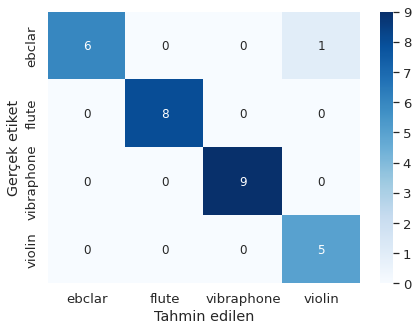

In [35]:
from sklearn.metrics import classification_report
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)
# Linear SVM modelini seçtik
selected_model = SVC(kernel='linear', C=0.025, random_state=0)
selected_model.fit(norm_x_train_val, y_train_val)
y_pred = selected_model.predict(norm_x_test)

siniflar = ['ebclar', 'flute', 'vibraphone', 'violin']
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                        columns=siniflar, index=siniflar)
conf_mat.index.name = 'Gerçek etiket'
conf_mat.columns.name = 'Tahmin edilen'
plt.figure(figsize=(7, 5))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, cmap='Blues', annot_kws={'size': 12}, annot=True)

print('Test kümesi örnek sayısı:', len(y_pred))
print(classification_report(y_test, y_pred, target_names=siniflar))

Şekil 7.10: Karıştırma matrisi

### Peki derin öğrenme modellerini kullanabilir miyiz?

Derin öğrenme modellerinin performansı veri sayısının fazla olduğu durumlarda konvansiyonel modelleri aşmaktadır. 
Elimizdeki veri boyutu küçük olduğu için derin öğrenme modellerinin daha yüksek başarı göstermesini beklemiyoruz. Yine de altta bir örnek sunuyoruz.


In [36]:
# Yine verimizi eğitim ve test altkümelerine bölerek başlayalım
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1)
# ..ve normalizasyon uygulayalım
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)


Sinir ağımız çıkış katmanında 4 (kategori sayısı kadar) nöron içerecek ve her nöron'un çıkışı ilgili örneğin o kategoriye ait olma olasılığını verecek. Bu, çıktının 0-1 arası değerler taşıyan 4 boyutlu bir vektör olduğu anlamına gelir. Eğitime başlayabilmek için elimizdeki etiket verilerini de bu temsile çevirmeliyiz. 
Örneğin: `'violin'` sınıfına ait bir örnek 3 etiketi ile temsil ediliyor. Bunu yukarıda bahsedilen 4 boyutlu vektör şeklinde temsil ettiğimizde [0 0 0 1] vektörünü elde ederiz. Benzer şekilde bir `'ebclar'` örneği için etiket 0 ve 4 boyutlu vektör temsili [1 0 0 0] olacaktır. Bu çeşit temsile **one-hot encoding** ismi verilmektedir. Bazen Türkçe makalelerde bu terim için "bir-sıcak temsil" gibi anlaşılması zor karşılıklar da kullanılmaktadır.

In [37]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(
    y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print('One-hot encoding, y_train_val boyutu =', y_train_val_onehot.shape)
print('One-hot encoding, y_test boyutu =', y_test_onehot.shape)

One-hot encoding, y_train_val boyutu = (115, 4)
One-hot encoding, y_test boyutu = (29, 4)


Yapay sinir ağ modelimizi Keras kütüphanesini kullanarak tanımlayalım ve model özetini inceleyelim.

In [38]:
from keras.models import Sequential
from keras import layers


def model_olustur(oznitelik_sayisi):
    model = Sequential()

    # Giriş katmanı
    model.add(layers.BatchNormalization(
        name='InputLayer', input_shape=(oznitelik_sayisi,)))

    # 1. saklı katman
    model.add(layers.Dense(name='HiddenLayer_1', units=32))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # 2. saklı katman
    model.add(layers.Dense(name='HiddenLayer_2', units=16))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Çıkış katmanı
    model.add(layers.Dense(name='Output_layer', units=4))
    model.add(layers.Activation('softmax'))

    return model


model = model_olustur(X_train_val.shape[1])
# model özetini inceleyelim
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (BatchNormalizat  (None, 78)               312       
 ion)                                                            
                                                                 
 HiddenLayer_1 (Dense)       (None, 32)                2528      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 HiddenLayer_2 (Dense)       (None, 16)                5

Eğitim için bir optimizasyon algoritması seçip modeli derleyelim ve eğitimi başlatalım.

In [39]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot,
                    batch_size=32, epochs=100, validation_split=0.3, verbose=1,)

Epoch 1/100
3/3 [==============================] - 1s 102ms/step - loss: 1.5135 - accuracy: 0.3500 - val_loss: 1.3719 - val_accuracy: 0.4000
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 1.4488 - accuracy: 0.2500 - val_loss: 1.3210 - val_accuracy: 0.4000
Epoch 3/100
3/3 [==============================] - 0s 12ms/step - loss: 1.3733 - accuracy: 0.3875 - val_loss: 1.2762 - val_accuracy: 0.4286
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 1.4244 - accuracy: 0.3375 - val_loss: 1.2323 - val_accuracy: 0.4571
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 1.3501 - accuracy: 0.3625 - val_loss: 1.1904 - val_accuracy: 0.5143
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 1.1919 - accuracy: 0.5000 - val_loss: 1.1547 - val_accuracy: 0.5143
Epoch 7/100
3/3 [==============================] - 0s 13ms/step - loss: 1.2286 - accuracy: 0.4625 - val_loss: 1.1234 - val_accuracy: 0.5429
Epoch 8/100
3/3 [==

Modelimiz eğitildi. `'accuracy'` modelin eğitim verisini ne düzeyde sınıflandırabildiğini, `'val_accuracy'` ise modelin validasyon verisini ne düzeyde sınıflandırabildiğini gösteriyor. İki değer de 1'e yakın, sonuç iyi görünüyor. 

Bu modelden memnun olduğumuzu varsayalım ve son olarak test verisindeki başarıyı raporlayalım.

In [40]:
score = model.evaluate(X_test, y_test_onehot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2821633815765381
Test accuracy: 0.8620689511299133


Eğitim/öğrenme sürecinde her bir 'epoch'ta çıktıların nasıl değiştiğinin görselleştirilmesi yaygın bir uygulamadır. Bu, eğitim için yapılan seçimler (optimizasyon algoritması, epoch sayısı, vb.) ve modelin eğitim verisini ezberleyip ezberlemediği konusunda gözlemler yapmamıza imkan tanır. Son olarak eğitim eğrilerini çizdirelim.

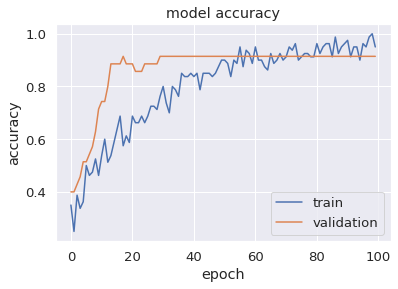

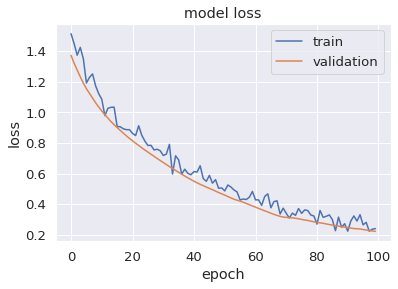

In [41]:
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Şekil 7.11: Öğrenme eğrileri 

## Egzersiz/Ödev

Bu bölümde otomatik enstrüman sınıflandırması için bir örnek gördünüz. Şimdi isterseniz başka bir veri kümesinde aynı deneyi tekrarlamayı deneyebilirsiniz. Bunun için CompMusic projesinde toplanmış verilerden
[Mridangam Stroke dataset](https://compmusic.upf.edu/mridangam-stroke-dataset)ini kullanabilirsiniz. Amaç 10 farklı vuruş sınıfını veya 6 farklı tonik sınıfını en yüksek doğruluk ile sınıflandırabilen bir sistemi tasarlamak. 

Bu bölümde yapılana benzer şekilde tasarımınızı gerçekleştirdikten sonra isterseniz özniteliklere boyut azaltma (dimensionality reduction) tekniklerini uygulayıp performansa etkisini gözleyebilirsiniz. 

**Yazar:** Barış Bozkurt, **editör:** Ahmet Uysal

---

